In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
import warnings
from copy import deepcopy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import nltk
from gensim.models import Word2Vec
import gensim.downloader as api

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

In [2]:
df = pd.read_csv('../data/processed_essays.csv')
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_tokenize_text,corrected_text,...,num_mistakes,lemmatized_text,sent_count,sent_len,word_count,noun_count,verb_count,adjective_count,adverb_count,score_category
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students would benefit learning home cha...,think students would benefit learning home cha...,...,0,think student would benefit learn home change ...,18,14,261,54,25,24,6,medium
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...,problem change let best matter happening chang...,...,0,problem change let best matter happen change m...,14,38,533,102,51,38,9,low
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal change school policy grade aver...,dear principal change school policy grade aver...,...,0,dear principal change school policy grade aver...,19,16,320,56,20,30,5,medium
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...,best time life become agree greatest accomplis...,...,0,best time life become agree great accomplishme...,36,20,728,106,73,62,22,high
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...,small act kindness impact people change people...,...,7,small act kindness impact people change people...,3,78,234,58,21,18,5,medium


In [3]:
target_columns = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
drop_columns = ["text_id", "full_text", "cleaned_tokenize_text", "corrected_text", "mistakes",
                "corrected_words", "score_category"]
feature_columns = ["num_mistakes", "sent_count", "sent_len", "word_count", "noun_count", "verb_count",
                   "adjective_count", "adverb_count"]
y = df[target_columns].copy()
df = df.drop(drop_columns + target_columns, axis=1)
df = df[["lemmatized_text"] + feature_columns]
df.head()

,lemmatized_text,num_mistakes,sent_count,sent_len,word_count,noun_count,verb_count,adjective_count,adverb_count
0,think student would benefit learn home change ...,0,18,14,261,54,25,24,6
1,problem change let best matter happen change m...,0,14,38,533,102,51,38,9
2,dear principal change school policy grade aver...,0,19,16,320,56,20,30,5
3,best time life become agree great accomplishme...,0,36,20,728,106,73,62,22
4,small act kindness impact people change people...,7,3,78,234,58,21,18,5


In [4]:
y.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5


In [5]:
def token_to_vector(corpus, model, vector_size):
    """
    Generate vectors for list of documents using a Word Embedding

    Args:
        corpus: List of documents
        model: Gensim's Word Embedding

    Returns:
        Document level embeddings
    """
    features = []

    for c in corpus:
        vectors = []
        for token in c:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)  # Take the mean since we need a 2D array instead of 3D
            features.append(avg_vec)
        else:
            features.append(np.zeros(vector_size))
    return np.array(features)

In [6]:
def featurize_text(df, column="lemmatized_text", method="CountVectorizer"):
    """
    Generate embeddings using various methods
    """
    if method == "CountVectorizer":
        model = CountVectorizer()
    elif method == "Tfidf-1gram":
        model = TfidfVectorizer(ngram_range=(1, 1), min_df=10)
    elif method == "Tfidf-2gram":
        model = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
    else:
        tokens = df[column].apply(lambda x: x.split())
        if method == "Word2Vec":
            model = Word2Vec(sentences=tokens, vector_size=100, workers=15, seed=SEED)
            X = token_to_vector(tokens, model.wv, 100)
        else:
            model = api.load("glove-wiki-gigaword-200")
            X = token_to_vector(tokens, model, model.vector_size)
        X = pd.DataFrame(data=X, columns=[f"f{i+1}" for i in range(X.shape[1])])
    
    if method not in ["Word2Vec", "Glove"]:
        X = model.fit_transform(df[column])
        X = pd.DataFrame(X.toarray(), columns=model.get_feature_names_out())
    
    X = pd.concat([X, df[feature_columns]], axis=1)
    return X, model

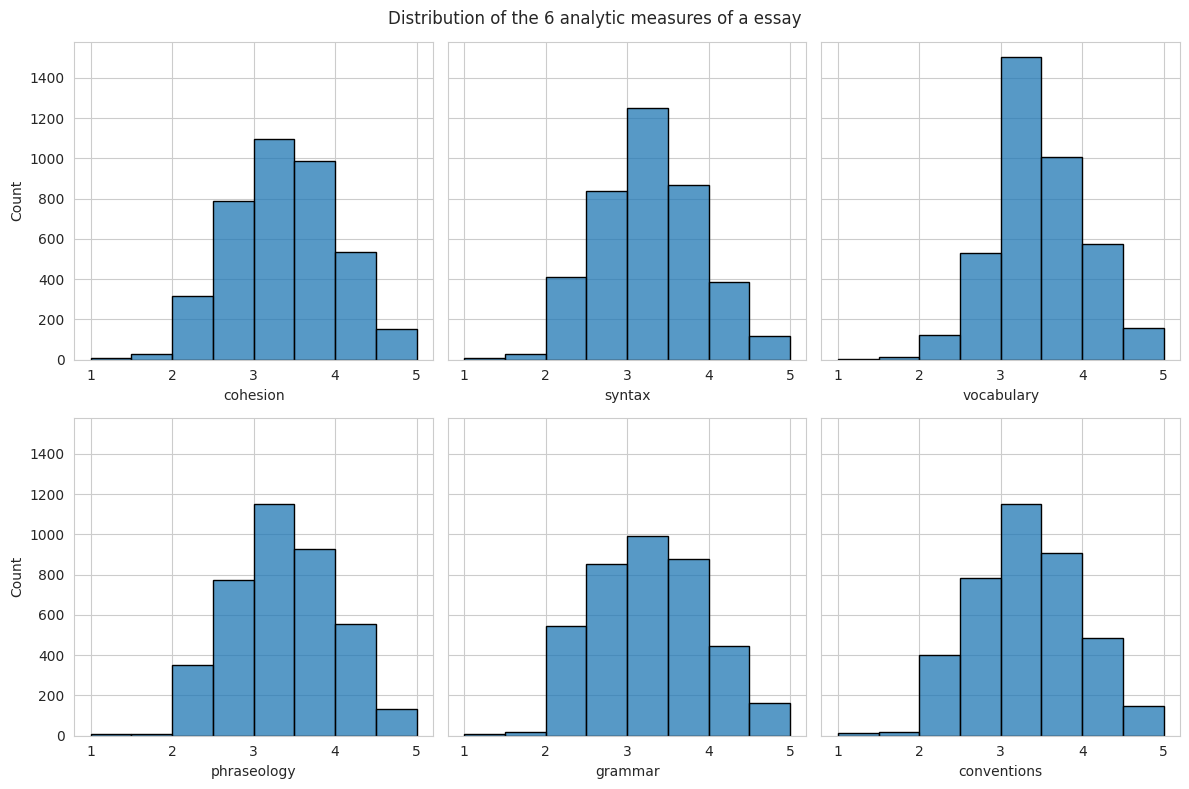

In [7]:
# Check the distribution of the 6 target variables

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(12, 8))

for i, c in enumerate(y.columns):
    sns.histplot(y[c], ax=axes[i//3, i%3], bins=8, edgecolor='k')

fig.suptitle("Distribution of the 6 analytic measures of a essay")
plt.tight_layout()
plt.show()

<b>We see a low scored essays are fewer in number</b>

In [8]:
def get_metrics(y1, p1, y2, p2, fold, model, feature, target):
    """
    Get various error metrics to check model performance
    """
    metrics = {
        "Training RMSE": mean_squared_error(y1, p1, squared=False),
        "Testing RMSE": mean_squared_error(y2, p2, squared=False),
        "Training MAE": mean_absolute_error(y1, p1),
        "Testing MAE": mean_absolute_error(y2, p2),
        "Fold #": fold,
        "Feature": feature,
        "Model": model
    }
    if target:
        metrics["target"] = target.capitalize()
    return np.round(pd.DataFrame([metrics]), 4)

In [9]:
def train_model(X_train, y_train, X_test, model):
    """
    Given train-test data and a model object, train a model and return predictions
    """
    model = deepcopy(model)
    model.fit(X_train, y_train)
    
    p1 = model.predict(X_train)
    p2 = model.predict(X_test)
    return p1, p2, model

In [10]:
# Initialize a dictionary of model objects. We also tried Linear Regression but the performance was quite poor
# So we decided to drop it

models = {
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=15, random_state=SEED),
    "SVM": SVR(),
    "XGBoost": XGBRegressor(n_estimators=50, max_depth=8, n_jobs=15, random_state=SEED)
}

In [11]:
# Train models for all combinations of embeddings, 5-folds, targets and models

results = []
pbar = tqdm(total=5*5*6*2 + 2*5*6)

for method in ["CountVectorizer", "Tfidf-1gram", "Tfidf-2gram", "Word2Vec", "Glove"]:  # For each word embedding
    X, _ = featurize_text(df, method=method)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    for i, (train_index, test_index) in enumerate(kfold.split(X)):  # Train 5 fold models
        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for t in target_columns:  # For each of the 6 targets
            y_train = y[t][train_index]
            y_test = y[t][test_index]

            for k, v in models.items():  # Train multiple models
                
                # Don't train SVM for CV and TF-IDF because it takes a long time to train due to huge
                # dimension size of the input features
                if method not in ["Word2Vec", "Glove"] and k == "SVM":
                    pbar.update()
                    continue
                train_pred, test_pred, _ = train_model(X_train, y_train, X_test, v)
                results.append(get_metrics(y_train, train_pred, y_test, test_pred, i + 1, k, method, t))

                pbar.update()

results = pd.concat(results)
results.to_csv("../data/results_df.csv", index=False)

  0%|          | 0/360 [00:00<?, ?it/s]

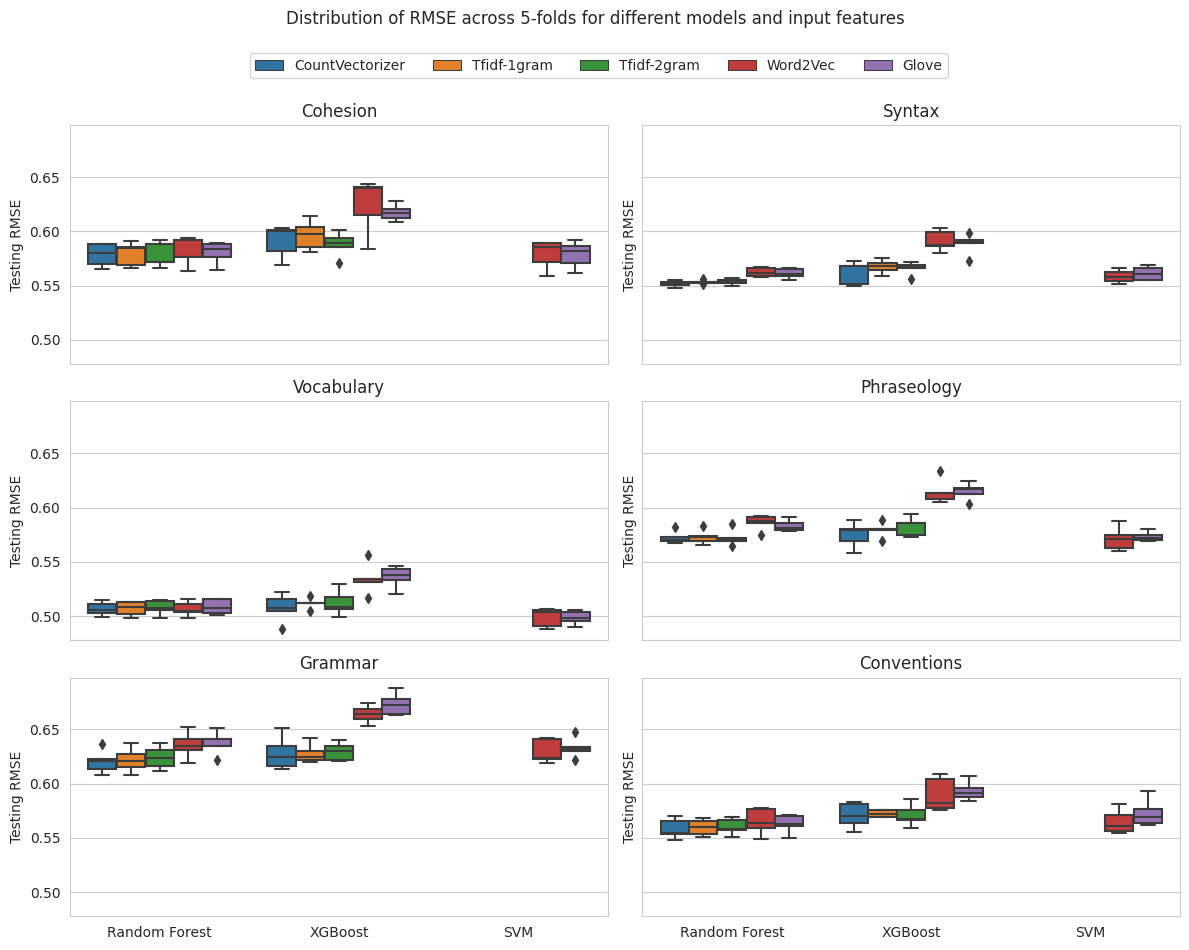

In [12]:
# Visualize the distribution of RMSE for all combinations

fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=True)

for i, t in enumerate(target_columns):
    sns.boxplot(data=results[results.target == t.capitalize()],
                y="Testing RMSE", x="Model", hue="Feature", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel("")
    axes[i//2, i%2].set_title(t.capitalize())

for i in range(3):
    for j in range(2):
        axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="", ncol=5, bbox_to_anchor=(0.8, 1.01))

fig.suptitle("Distribution of RMSE across 5-folds for different models and input features", y=1.05)

plt.tight_layout()
plt.show()

In [13]:
# Find the best combination of models and embeddings for each target
best_models = results.groupby(['target', 'Feature', 'Model'])['Testing RMSE', 'Testing MAE'].mean()
best_models = best_models.loc[best_models.groupby('target')['Testing RMSE'].idxmin()].reset_index()
best_models

,target,Feature,Model,Testing RMSE,Testing MAE
0,Cohesion,CountVectorizer,Random Forest,0.57844,0.46638
1,Conventions,CountVectorizer,Random Forest,0.55822,0.44088
2,Grammar,CountVectorizer,Random Forest,0.62046,0.50392
3,Phraseology,Word2Vec,SVM,0.57138,0.45546
4,Syntax,CountVectorizer,Random Forest,0.55192,0.44240
5,Vocabulary,Glove,SVM,0.49878,0.39066


In [14]:
# Train and save a new model for each of the above identified pairs

model_dict = {}
for i in tqdm(range(len(best_models))):
    t = best_models.target[i].lower()
    f = best_models.Feature[i]
    m = best_models.Model[i]
    
    X, fmodel = featurize_text(df, method=f)
    X_train, X_test, y_train, y_test = train_test_split(X, y[t], random_state=SEED)
    
    scaler = StandardScaler()
    
    features = X_train.columns
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(data=X_train, columns=features)
    
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(data=X_test, columns=features)
    
    _, y_pred, model = train_model(X_train, y_train, X_test, models[m])
    
    model_dict[t] = (fmodel, scaler, model)


with open("../data/best_models.p", "wb") as f:
    pickle.dump(model_dict, f)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# We tried some methods to improve the models below but it didn't work

In [16]:
### Improve the models

In [15]:
#### The problem with building separate models for each target variable is that it's missing on sharing information between the models

In [17]:
# results2 = []
# pbar = tqdm(total=5*5)

# for method in ["CountVectorizer", "Tfidf-1gram", "Tfidf-2gram", "Word2Vec", "Glove"]:
#     X, _ = featurize_text(df, method=method)
    
#     kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
#     for i, (train_index, test_index) in enumerate(kfold.split(X)):
#         X_train = X.iloc[train_index, :]
#         X_test = X.iloc[test_index, :]
        
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)

#         y_train = y.iloc[train_index, :]
#         y_test = y.iloc[test_index, :]

#         train_pred, test_pred, _ = train_model(X_train, y_train, X_test, models["Random Forest"])
#         results2.append(get_metrics(y_train, train_pred, y_test, test_pred, i + 1, "Random Forest", method, None))

#         pbar.update()

# results2 = pd.concat(results2)
# results2.to_csv("../data/results_df2.csv", index=False)

In [18]:
# for i in range(6):
#     print(mean_squared_error(y_test.values[:, i], y_pred[:, i], squared=False))

In [19]:
# plt.figure(figsize=(12, 6))

# sns.boxplot(data=results2, y="Testing RMSE", x="Feature")

# plt.show()

In [20]:
# best_models = results2.groupby(['target', 'Feature'])['Testing RMSE', 'Testing MAE'].mean()
# best_models = best_models.loc[best_models.groupby('target')['Testing RMSE'].idxmin()].reset_index()
# best_models